In [4]:
from google.colab import drive
drive.mount('/content/drive')

import os
import pickle

os.chdir("/content/drive/MyDrive/Reconocimiento de Patrones")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data loading

In [5]:

import os
import pickle


with open('preprocessed_data.pickle', 'rb') as file:
    filt_dict = pickle.load(file)
    segm_dict = pickle.load(file)
    norm_segm_dict = pickle.load(file)

# Segmentación

In [6]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Calcula la longitud de todas las secuencias
lengths = [len(seq) for seq in norm_segm_dict['ABP']]  # Asumiendo ABP como referencia; también puedes combinar las longitudes de CBFV y ICP si es necesario

# Usa el percentil 95 para determinar max_len
max_len = int(np.percentile(lengths, 95))

print("Longitud de padding seleccionada:", max_len)

# Asumiendo que has calculado max_len como se indicó antes
norm_segm_dict['ABP'] = pad_sequences(norm_segm_dict['ABP'], maxlen=max_len, dtype='float32', padding='post', truncating='post')
norm_segm_dict['CBFV'] = pad_sequences(norm_segm_dict['CBFV'], maxlen=max_len, dtype='float32', padding='post', truncating='post')
norm_segm_dict['ICP'] = pad_sequences(norm_segm_dict['ICP'], maxlen=max_len, dtype='float32', padding='post', truncating='post')

Longitud de padding seleccionada: 122


# LSTM for ICP waveform

In [7]:
from sklearn.model_selection import train_test_split

X = np.stack((norm_segm_dict['ABP'], norm_segm_dict['CBFV']), axis=-1)  # Forma: [num_samples, timesteps, num_channels]
y = norm_segm_dict['ICP']

y_or = segm_dict['ICP']

original_lengths = np.array([len(seq) for seq in y_or])

# Crear un arreglo de índices
indices = np.arange(len(X))

# Primero dividir en entrenamiento y prueba
indices_train, indices_test = train_test_split(indices, test_size=0.1, random_state=110)

# Dividir el conjunto de entrenamiento en entrenamiento y validación
indices_train, indices_val = train_test_split(indices_train, test_size=0.2, random_state=110)  # 0.25 x 0.8 = 0.2

# Usar estos índices para dividir tus datos originales y estadísticos
X_train, X_val, X_test = X[indices_train], X[indices_val], X[indices_test]
y_train, y_val, y_test = y[indices_train], y[indices_val], y[indices_test]

train_lengths, val_lengths, test_lengths = original_lengths[indices_train], original_lengths[indices_val], original_lengths[indices_test]

In [8]:
import numpy as np
import keras.backend as K
from keras.callbacks import Callback

class CyclicLR(Callback):
    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular', gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()
        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        self.scale_fn = scale_fn
        self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        if self.scale_fn is None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1 / (2. ** (x - 1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: self.gamma ** (x)
                self.scale_mode = 'iterations'

    def clr(self):
        cycle = np.floor(1 + self.clr_iterations / (2 * self.step_size))
        x = np.abs(self.clr_iterations / self.step_size - 2 * cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr - self.base_lr) * np.maximum(0, (1 - x)) * self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr - self.base_lr) * np.maximum(0, (1 - x)) * self.scale_fn(self.clr_iterations)

    def on_train_begin(self, logs=None):
        logs = logs or {}
        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())

    def on_batch_end(self, epoch, logs=None):
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        K.set_value(self.model.optimizer.lr, self.clr())
        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

# Crear una instancia del callback con los parámetros deseados
clr = CyclicLR(base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular2')

In [9]:
!pip install tensorboard


In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import Huber
from tensorflow.keras.layers import LSTM, Dense, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, Callback
import datetime
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Reshape

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=(122,2),padding='same'))
model.add(MaxPooling1D(pool_size=1))
model.add(Bidirectional(LSTM(50, return_sequences=True)))
model.add(TimeDistributed(Dense(1)))

model.output

<KerasTensor: shape=(None, 122, 1) dtype=float32 (created by layer 'time_distributed')>

In [11]:
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
loss = Huber(delta=1.0)  # Puede ser 'mae' o Huber()

model.compile(optimizer=optimizer, loss=loss, metrics=['mae'])

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model.fit(X_train, y_train, epochs=75, batch_size=64, validation_data=(X_val, y_val), callbacks=[clr, tensorboard_callback])

Epoch 1/75
  6/597 [..............................] - ETA: 15s - loss: 0.2197 - mae: 0.4922

597/597 [==============================] - 27s 22ms/step - loss: 0.0993 - mae: 0.2950 - val_loss: 0.0800 - val_mae: 0.2577
Epoch 2/75
597/597 [==============================] - 9s 15ms/step - loss: 0.0686 - mae: 0.2377 - val_loss: 0.0597 - val_mae: 0.2182
Epoch 3/75
597/597 [==============================] - 9s 16ms/step - loss: 0.0544 - mae: 0.2059 - val_loss: 0.0474 - val_mae: 0.1919
Epoch 4/75
597/597 [==============================] - 10s 16ms/step - loss: 0.0462 - mae: 0.1842 - val_loss: 0.0411 - val_mae: 0.1678
Epoch 5/75
597/597 [==============================] - 9s 15ms/step - loss: 0.0390 - mae: 0.1630 - val_loss: 0.0382 - val_mae: 0.1632
Epoch 6/75
597/597 [==============================] - 10s 17ms/step - loss: 0.0348 - mae: 0.1501 - val_loss: 0.0319 - val_mae: 0.1394
Epoch 7/75
597/597 [==============================] - 10s 17ms/step - loss: 0.0312 - mae: 0.1369 - val_loss: 0.0307 - val_mae: 0.1339
Epoch 8/75
597/597 [==============================] - 9s 15ms/step - loss: 0

# Overfitting check before saving


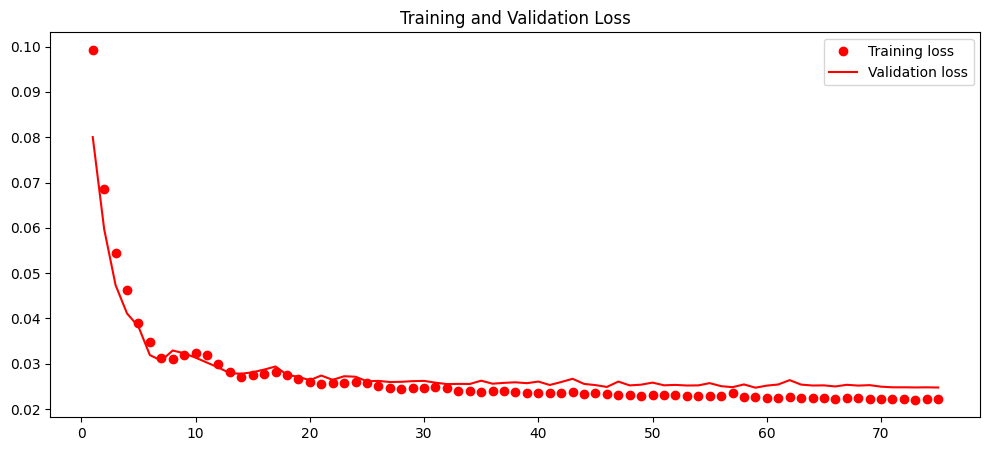

In [12]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, 75 + 1)
    plt.figure(figsize=(12, 5))
    plt.plot(epochs, loss, 'ro', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

plot_training_history(history)

In [13]:
model.save('ModelosLSTM/model1e.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Pruebas Waveform

166/166 [==============================] - 2s 5ms/step


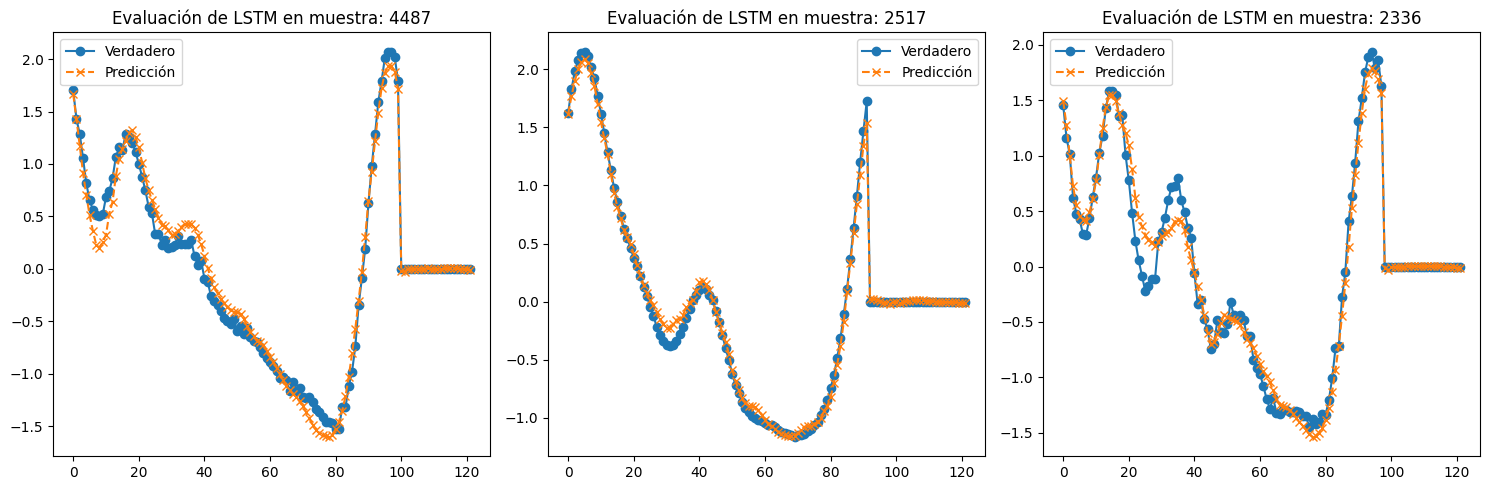

In [14]:
import numpy as np

# Obtener las predicciones del modelo
predictions = model.predict(X_test)
predictions_trimmed = [pred[:length] for pred, length in zip(predictions, test_lengths)]
y_test_trimmed = [pred[:length] for pred, length in zip(y_test, test_lengths)]

# Seleccionar 20 índices aleatorios para mostrar
num_examples = 3
indices = np.random.choice(len(predictions_trimmed), num_examples, replace=False)
indices = [4486, 2516, 2335]

# Configurar la figura para mostrar múltiples subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))  # Ajusta el tamaño de la figura según necesidad
axes = axes.flatten()  # Aplanar el array de axes para una iteración más fácil

for idx, ax in zip(indices, axes):
    ax.plot(y_test[idx], label='Verdadero', marker='o', linestyle='-')
    ax.plot(predictions[idx], label='Predicción', marker='x', linestyle='--')
    ax.set_title(f'Evaluación de LSTM en muestra: {idx+1}')
    ax.legend()

# Ajustar el layout para evitar la superposición de subplots
plt.tight_layout()
plt.show()

# Imprimir las dimensiones para referencia
print("y_test shape:", y_test.shape)
print("predictions shape:", predictions.shape)